<a href="https://colab.research.google.com/github/ranjani277/Dynamic-Price-Prediction/blob/main/Dynamic_Price_Prediction_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dynamic Price Prediction **

**Case Study**

Uber and Lyft's ride prices are not constant like public transport. They are greatly affected by the demand and supply of rides at a given time. So what exactly drives this demand? The first guess would be the time of the day; times around 9 am and 5 pm should see the highest surges on account of people commuting to work/home. Another guess would be the weather; rain/snow should cause more people to take rides.

The data is approx. for a week of Nov '18 ( I actually have included data collected while I was testing the 'querying' application so might have data spread out over more than a week. I didn't consider this as a time-series problem so did not worry about regular interval. The chosen interval was to query as much as data possible without unnecessary redundancy. So data can go from end week of Nov to few in Dec) The Cab ride data covers various types of cabs for Uber & Lyft and their price for the given location. You can also find if there was any surge in the price during that time. Weather data contains weather attributes like temperature, rain, cloud, etc for all the locations taken into consideration.
By finding the most related factors that affect fare prices, we will first use  XGBoost Regression, LGBM Regression and Gradiant BoostRegressor models to find the most accurate model for prediction. Then, we will use feature importance to pinpoint the most important factors that influence price for Uber and Lyft separately.

**About Dataset**

Accessing  data, cab_rides, and weather datasets provides a valuable opportunity to delve into the dynamics of Uber and Lyft taxi prices during the week of November-December 2018. The cab_rides data set consists of 10 columns and 693,070 rows and provides a comprehensive view of the various types of taxis offered by Uber and Lyft, including pricing and location information.

The weather dataset has 8 columns and 6,275 rows and provides information about weather attributes for various locations and books. This includes temperature, precipitation (rain) and cloud cover information. Integrating weather data into the analysis can provide a better understanding of how external factors such as weather conditions affect Uber and Lyft prices.

*Data description for cab_rides*

*Column                              Description*

distance	    -----    distance between source and destination
  
cab_type	    -----  Uber or Lyft

time_stamp	  ----  epoch time when data was queried

destination 	-----  destination of the ride

source        -----   starting point of the ride

price	         -----  estimate for the ride in USD

surge_multiplier -----the multiplier by which price was increased, default 1

id	             ----- unique identifier

product_id	   -----   uber/lyft identifier for cab-type

name	         -----   Visible type of the cab eg: Uber Pool, UberXL





*Data description for weather*

*Column               	Description*

temp	     -----       Temperature in F

location	-----        Location name

clouds	    -----      Clouds

pressure	  -----      pressure in mb

rain	     -----       rain in inches for the last hr

time_stamp	-----      epoch time when row data was collected

humidity	-----        thumidity in %

wind	    -----        wind speed in mph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Aug 14 09:05:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Importing** **Dataset**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
car_df=pd.read_csv('/content/drive/MyDrive/cab_rides.csv')
weather_df=pd.read_csv('/content/drive/MyDrive/weather.csv')

We need to identify the charecteristics of our dataset .For this we use three methods:-
info()-Used for identifying the different features and data types in a dataset.
shape()-We used this method to get an idea of the rows and columns in a dataframe.
head()-We used this method to examine the first few rows of the dataset
describe()-We used this method to identify the summary statistic's of all the features of the dataset.

In [ ]:
car_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          693071 non-null  float64
 1   cab_type          693071 non-null  object 
 2   time_stamp        693071 non-null  int64  
 3   destination       693071 non-null  object 
 4   source            693071 non-null  object 
 5   price             637976 non-null  float64
 6   surge_multiplier  693071 non-null  float64
 7   id                693071 non-null  object 
 8   product_id        693071 non-null  object 
 9   name              693071 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 52.9+ MB


In [ ]:
car_df.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.189430,1.544046e+12,16.545125,1.013870
std,1.138937,6.891925e+08,9.324359,0.091641
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


In [ ]:
weather_df.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6276 entries, 0 to 6275
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        6276 non-null   float64
 1   location    6276 non-null   object 
 2   clouds      6276 non-null   float64
 3   pressure    6276 non-null   float64
 4   rain        894 non-null    float64
 5   time_stamp  6276 non-null   int64  
 6   humidity    6276 non-null   float64
 7   wind        6276 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 392.4+ KB


In [ ]:
weather_df.describe()

,temp,clouds,pressure,rain,time_stamp,humidity,wind
count,6276.000000,6276.000000,6276.000000,894.000000,6.276000e+03,6276.000000,6276.000000
mean,39.090475,0.677777,1008.445209,0.057652,1.543857e+09,0.763985,6.802812
std,6.022055,0.314284,12.870775,0.100758,6.659340e+05,0.127340,3.633466
min,19.620000,0.000000,988.250000,0.000200,1.543204e+09,0.450000,0.290000
25%,36.077500,0.440000,997.747500,0.004900,1.543387e+09,0.670000,3.517500
50%,40.130000,0.780000,1007.660000,0.014850,1.543514e+09,0.760000,6.570000
75%,42.832500,0.970000,1018.480000,0.060925,1.544691e+09,0.890000,9.920000
max,55.410000,1.000000,1035.120000,0.780700,1.545159e+09,0.990000,18.180000


In [ ]:
car_df.isnull().sum()

,0
distance,0
cab_type,0
time_stamp,0
destination,0
source,0
price,55095
surge_multiplier,0
id,0
product_id,0
name,0


**Data Cleaning**

Aligning cab_rides and weather units

Since the car_df and weather_df use different time frequencies, we added a new column "merge_date" to take the average weather data by hour, and matched it to the trips table on the hour extracted from the timestamp.

In [ ]:
# Unifing timestamp format and turn to datetime
car_df['date_time'] = pd.to_datetime(car_df['time_stamp']/1000, unit='s')
weather_df['date_time'] = pd.to_datetime(weather_df['time_stamp'], unit='s')
car_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000128
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.197999872
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000192
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000064


In [ ]:
# Create a new column for merging, and imputing rain columns with 0
car_df['merge_date'] = car_df.source.astype(str) +" - "+ car_df.date_time.dt.date.astype("str") +" - "+ car_df.date_time.dt.hour.astype("str")
weather_df['merge_date'] = weather_df.location.astype(str) +" - "+ weather_df.date_time.dt.date.astype("str") +" - "+ weather_df.date_time.dt.hour.astype("str")

In [ ]:
groupby_value = weather_df.groupby(['merge_date']).mean(numeric_only=True).reset_index()
groupby_value['rain'].fillna(0,inplace=True)

In [ ]:
# Merge two dataframe and drop NAN
groupby_value.index = groupby_value['merge_date']
merged_df = car_df.join(groupby_value,on=['merge_date'],rsuffix ='_w')
merged_df = merged_df[pd.notnull(merged_df['date_time'])]
merged_df = merged_df[pd.notnull(merged_df['price'])]
merged_df.dropna(inplace=True)

In [ ]:
merged_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,merge_date,merge_date_w,temp,clouds,pressure,rain,time_stamp_w,humidity,wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000128,Haymarket Square - 2018-12-16 - 9,Haymarket Square - 2018-12-16 - 9,38.460,0.290000,1022.25,0.000,1.544954e+09,0.760000,7.68
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936,Haymarket Square - 2018-11-27 - 2,Haymarket Square - 2018-11-27 - 2,44.065,0.995000,1002.88,0.106,1.543286e+09,0.895000,12.63
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000192,Haymarket Square - 2018-11-30 - 4,Haymarket Square - 2018-11-30 - 4,35.080,0.000000,1013.71,0.000,1.543554e+09,0.700000,5.25
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000064,Haymarket Square - 2018-11-29 - 3,Haymarket Square - 2018-11-29 - 3,37.680,0.433333,998.42,0.000,1.543461e+09,0.706667,11.16
5,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,2018-12-17 18:25:12.138000128,Haymarket Square - 2018-12-17 - 18,Haymarket Square - 2018-12-17 - 18,40.780,0.930000,1000.15,0.000,1.545072e+09,0.790000,7.55


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 635242 entries, 0 to 693070
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   distance          635242 non-null  float64       
 1   cab_type          635242 non-null  object        
 2   time_stamp        635242 non-null  int64         
 3   destination       635242 non-null  object        
 4   source            635242 non-null  object        
 5   price             635242 non-null  float64       
 6   surge_multiplier  635242 non-null  float64       
 7   id                635242 non-null  object        
 8   product_id        635242 non-null  object        
 9   name              635242 non-null  object        
 10  date_time         635242 non-null  datetime64[ns]
 11  merge_date        635242 non-null  object        
 12  merge_date_w      635242 non-null  object        
 13  temp              635242 non-null  float64       
 14  clouds   

In [ ]:
merged_df =merged_df[['distance','cab_type','destination','source','price','name','date_time','merge_date','temp','clouds','pressure','rain','humidity','wind']]

# Creating time period variable and mapping
merged_df['hour'] =merged_df['date_time'].dt.hour.astype(str)
mapping = {
    '6': 'morning','7' : 'morning','8' : 'morning','9' : 'morning',
    '10' : 'noon', '11' : 'noon','12' : 'noon', '13' : 'noon',
    '14' : 'afternoon', '15' : 'afternoon', '16' : 'afternoon', '17' : 'afternoon',
    '18' : 'evening', '19' : 'evening', '20' : 'evening', '21' : 'evening',
    '22' : 'night', '23' : 'night', '0' : 'night', '1' : 'night',
    '2' : 'night', '3' : 'late_night', '4' : 'late_night', '5' : 'late_night' }
merged_df['time_period'] =merged_df['hour'].replace(mapping)

merged_df.drop(columns=['date_time','merge_date','hour'],axis=1, inplace=True)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 635242 entries, 0 to 693070
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   distance     635242 non-null  float64
 1   cab_type     635242 non-null  object 
 2   destination  635242 non-null  object 
 3   source       635242 non-null  object 
 4   price        635242 non-null  float64
 5   name         635242 non-null  object 
 6   temp         635242 non-null  float64
 7   clouds       635242 non-null  float64
 8   pressure     635242 non-null  float64
 9   rain         635242 non-null  float64
 10  humidity     635242 non-null  float64
 11  wind         635242 non-null  float64
 12  time_period  635242 non-null  object 
dtypes: float64(8), object(5)
memory usage: 67.9+ MB


We are using an imputation technique to replace the missing price and rain values.

**Visualization**

Customers usually want to save money, so they usually open both apps to compare prices before making a decision. One of the main factors that affects prices is the distance between sources and destination. Using this data, we can look at the average price for each app based on distance traveled.

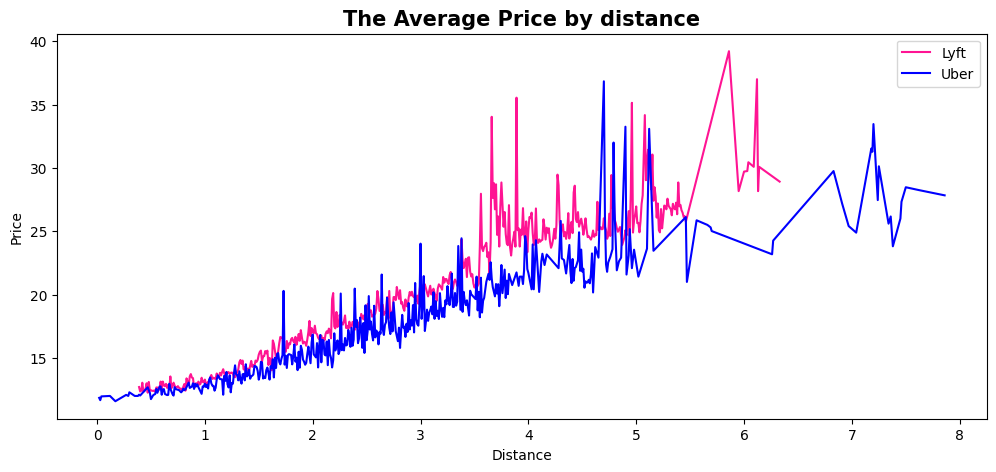

In [ ]:
# plotting distance against price
fig , ax = plt.subplots(figsize = (12,5))
ax.plot(merged_df[merged_df['cab_type'] == 'Lyft'].groupby('distance').price.mean().index,
        merged_df[merged_df['cab_type'] == 'Lyft'].groupby('distance').price.mean(),
        label = 'Lyft', color='deeppink')

ax.plot(merged_df[merged_df['cab_type'] == 'Uber'].groupby('distance').price.mean().index,
        merged_df[merged_df['cab_type'] =='Uber'].groupby('distance').price.mean(),
        label = 'Uber', color='blue')

ax.set_title('The Average Price by distance', fontsize= 15, fontweight='bold')
ax.set(xlabel = 'Distance', ylabel = 'Price' )
ax.legend()
plt.show()

From above figure, we can observe that for long-distance trips (distances exceeding 5 miles), Lyft tends to have a higher price. Therefore, it is advisable to opt for Uber in such cases.

However, for short-distance trips (distances less than 5 miles), Uber can occasionally have higher costs.

**Do Uber and Lyft have different prices for various vehicle types?**

Sometimes customers are traveling with friends or family and require a larger vehicle, and other times they seek luxury travel. Therefore, it becomes crucial to understand which apps customers should choose based on vehicle type.
Are u really think like that let's go and check...

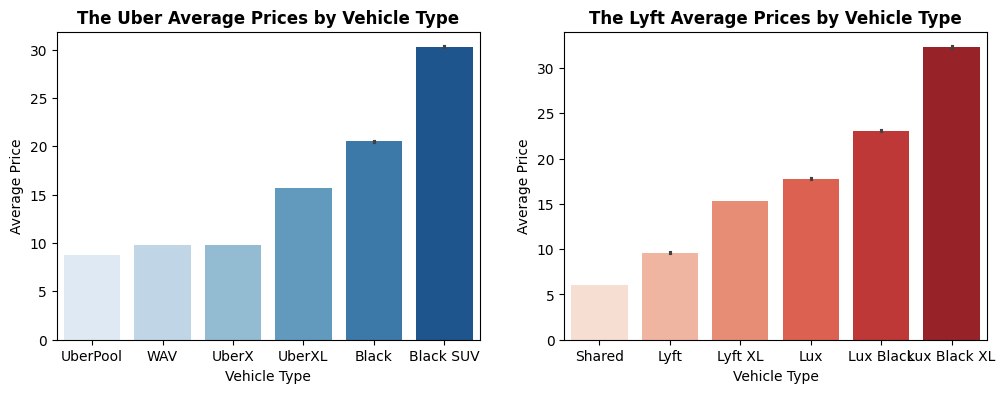

In [ ]:
# plotting Vehicle Type against average price
uber_order =[ 'UberPool','WAV', 'UberX', 'UberXL', 'Black','Black SUV' ]
lyft_order = ['Shared', 'Lyft', 'Lyft XL', 'Lux', 'Lux Black', 'Lux Black XL']
fig, ax = plt.subplots(1,2, figsize = (12,4))
ax1 = sns.barplot(x = merged_df[merged_df['cab_type'] == 'Uber'].name,
                  y = merged_df[merged_df['cab_type'] == 'Uber'].price ,
                  ax = ax[0], order = uber_order,palette='Blues')

ax2 = sns.barplot(x = merged_df[merged_df['cab_type'] == 'Lyft'].name,
                  y = merged_df[merged_df['cab_type'] == 'Lyft'].price ,
                  ax = ax[1], order = lyft_order,palette='Reds')

ax1.set(xlabel = 'Vehicle Type', ylabel = 'Average Price')
ax2.set(xlabel = 'Vehicle Type', ylabel = 'Average Price')

ax1.set_title('The Uber Average Prices by Vehicle Type', fontweight='bold')
ax2.set_title('The Lyft Average Prices by Vehicle Type', fontweight='bold')

plt.show()

The comparison of price differences across various vehicle types reveals distinct patterns. For premium services, Uber Black emerges as the more expensive option, making it the preferred choice for those seeking a high-end experience. On the other hand, Lyft's standard service (Lyft) tends to be more affordable than UberX, especially for smaller vehicle types. When it comes to shared rides, UberPool generally costs more than Lyft's Shared option. For larger vehicle types, such as XL, UberXL typically commands a higher price compared to LyftXL.



**How do prices vary based on different pick-up locations?**

It is possible that the pricing fluctuations are correlated with demand. Therefore, we would like to know whether there is a price difference among various pick-up locations. Understanding such variations can shed light on the impact of demand on pricing in different areas.

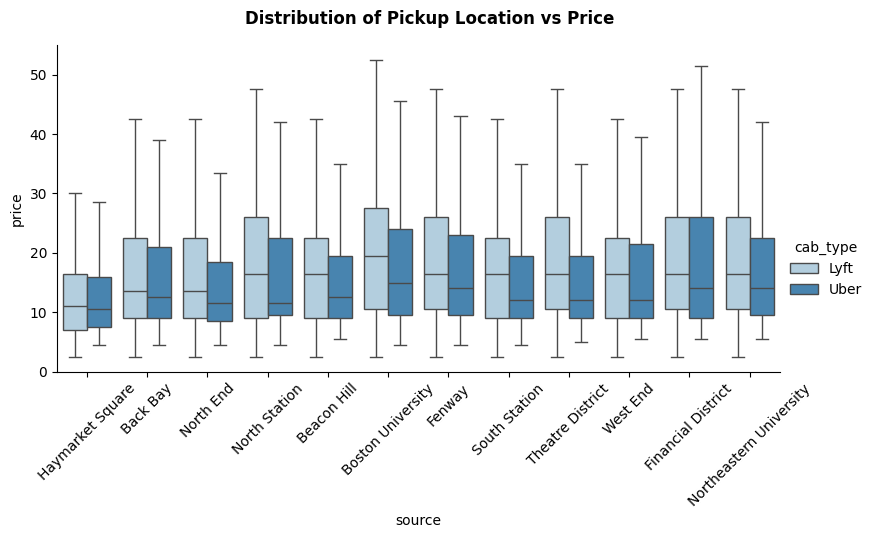

In [ ]:
# plotting source against price
sns.catplot(x='source', y='price', data=merged_df, kind='box', hue='cab_type',showfliers=False,height=4, aspect=2, palette='Blues', dodge=True)
plt.tick_params(axis='x', rotation=45)
plt.suptitle("Distribution of Pickup Location vs Price", y=1.05, fontweight='bold')
plt.show()

The box plot illustrates the price variations across different pickup locations. Notably, prices appear to be higher in areas such as Boston University, Fenway, and Northeastern University, likely due to increased demand in these bustling locations. Additionally, the Financial District exhibits a wider range of prices, which could be influenced by the varying distances of trips originating from this area.

**Modeling**

Which methods worked best for the problem?

We decided to implement three distinct search methods—GridSearch, and RandomizedSearch across four unique models— XGBoost Regression,LGBM Regressor and Gradiant Boost Regression—to achieve hyperparameter tuning. The goal was to identify the optimal models for both Uber and Lyft. To assess the models' performance, we compared the negative root mean squared error for each and selected the model with the highest value. Subsequently, we utilized the chosen model to make predictions on the test dataset.

In [ ]:
df_lyft = merged_df[merged_df['cab_type']=='Lyft'].copy()
df_uber = merged_df[merged_df['cab_type']=='Uber'].copy()

# Creating target and features
X_lyft = df_lyft.drop('price',axis=1)
y_lyft = df_lyft['price'].copy()

X_uber = df_uber.drop('price',axis=1)
y_yber = df_uber['price'].copy()

In [ ]:

X_train_lyft, X_test_lyft, y_train_lyft, y_test_lyft = train_test_split(X_lyft, y_lyft, test_size=0.3, random_state=0)
X_train_uber, X_test_uber, y_train_uber, y_test_uber = train_test_split(X_uber, y_yber, test_size=0.3, random_state=0)

In [ ]:
cat_attribs = ["cab_type", "destination", "source", "name", "time_period"]
num_attribs = ["distance", "temp", "clouds", "pressure", "rain", "humidity", "wind"]

preprocess_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(drop='first'), cat_attribs),
        ("num", StandardScaler(), num_attribs),])
preprocess_pipeline

ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'),
                                 ['cab_type', 'destination', 'source', 'name',
                                  'time_period']),
                                ('num', StandardScaler(),
                                 ['distance', 'temp', 'clouds', 'pressure',
                                  'rain', 'humidity', 'wind'])])

In [ ]:
#Create a def function for model pipeline
def train_and_evaluate_model(model, preprocess_pipeline, X_train, y_train, X_test):

    pipeline = make_pipeline(preprocess_pipeline, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmses = -cross_val_score(pipeline, X_train, y_train,
                             scoring="neg_root_mean_squared_error", cv=3)
    avg_rmse = rmses.mean()
    print(f"Average Cross-Validation RMSE: {avg_rmse:.0f}")

    return y_pred, avg_rmse


**XGBOOST REGRESSOR**

UBER

In [ ]:
# XGBRegressor for Uber DataFrame
y_pred_uber, xgb_rmses_uber = train_and_evaluate_model(XGBRegressor(), preprocess_pipeline, X_train_uber, y_train_uber, X_test_uber)


Average Cross-Validation RMSE: 2


In [ ]:
# XGBRegressor Grid Search for Uber DataFrame
param_grid = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}
xgb_uber = make_pipeline(preprocess_pipeline, XGBRegressor())
xgb_uber_grid_search = GridSearchCV(xgb_uber, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_uber_grid_search.fit(X_train_uber, y_train_uber)

#Evaluate Performance
y_pred_grid = xgb_uber_grid_search.predict(X_test_uber)
rmse_grid = np.sqrt(mean_squared_error(y_test_uber, y_pred_grid))
print(f"Grid Search RMSE: {rmse_grid}")


Grid Search RMSE: 1.8865310479496655


In [ ]:
# XGBRegressor  Random Search for Uber dataframe
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}

xgb_uber_Random_search = RandomizedSearchCV(xgb_uber, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_uber_Random_search.fit(X_train_uber, y_train_uber)

#Evaluate Performance
y_pred_Random = xgb_uber_Random_search.predict(X_test_uber)
rmse_Random = np.sqrt(mean_squared_error(y_test_uber, y_pred_Random))
print(f"Random Search RMSE: {rmse_Random}")

Random Search RMSE: 1.8865310479496655


LYFT

In [ ]:

# XGBRegressor for Lyft DataFrame
y_pred_lyft, xgb_rmses_lyft = train_and_evaluate_model(XGBRegressor(), preprocess_pipeline, X_train_lyft, y_train_lyft, X_test_lyft)


Average Cross-Validation RMSE: 3


In [ ]:
# XGB Grid Search for lyft dataframe
param_grid = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}
xgb_lyft = make_pipeline(preprocess_pipeline, XGBRegressor())
xgb_lyft_grid_search = GridSearchCV(xgb_lyft, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_lyft_grid_search.fit(X_train_lyft, y_train_lyft)

#Evaluate Performance
y_pred_grid = xgb_lyft_grid_search.predict(X_test_lyft)
rmse_grid = np.sqrt(mean_squared_error(y_test_lyft, y_pred_grid))
print(f"Grid Search RMSE: {rmse_grid}")


Grid Search RMSE: 2.9842104377780165


In [ ]:
# XGB Random Search for lyft dataframe
param_grid = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__max_depth': [3, 5],
    'xgbregressor__subsample': [0.8, 1.0],
}

xgb_lyft_Random_search = RandomizedSearchCV(xgb_lyft, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_lyft_Random_search.fit(X_train_lyft, y_train_lyft)

#Evaluate Performance
y_pred_Random = xgb_lyft_Random_search.predict(X_test_lyft)
rmse_Random = np.sqrt(mean_squared_error(y_test_lyft, y_pred_Random))
print(f"Random Search RMSE: {rmse_Random}")

Random Search RMSE: 2.9835196562685606


**LGBM REGRESSOR**

UBER

In [ ]:
y_pred_uber_lg, lgb_rmses_uber = train_and_evaluate_model(LGBMRegressor(), preprocess_pipeline, X_train_uber, y_train_uber, X_test_uber)

Average Cross-Validation RMSE: 2


In [ ]:
# LGBM Regressor Grid Search for Uber
param_grid = {
    'lgbmregressor__n_estimators': [50, 100],
    'lgbmregressor__learning_rate': [0.1,0.01],
    'lgbmregressor__num_leaves': [31, 50]
}
lgbm_uber = make_pipeline(preprocess_pipeline, LGBMRegressor())
lgbm_uber_grid_search = GridSearchCV(lgbm_uber, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_uber_grid_search.fit(X_train_uber, y_train_uber)

#Evaluate Performance
y_pred_grid_lg = lgbm_uber_grid_search.predict(X_test_uber)
rmse_grid_lg = np.sqrt(mean_squared_error(y_test_uber, y_pred_grid_lg))
print(f"Grid Search RMSE: {rmse_grid_lg}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1716
[LightGBM] [Info] Number of data points in the train set: 230398, number of used features: 39
[LightGBM] [Info] Start training from score 15.793855
Grid Search RMSE: 1.875484329053885


In [ ]:
# LGBM Regressor Random Search for Uber DataFrame
param_grid = {
      'lgbmregressor__n_estimators': [50, 100],
    'lgbmregressor__learning_rate': [0.1,0.01],
    'lgbmregressor__num_leaves': [31, 50]
}

lgb_uber_Random_search = RandomizedSearchCV(lgbm_uber, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgb_uber_Random_search.fit(X_train_uber, y_train_uber)

#Evaluate Performance
y_pred_Random = lgb_uber_Random_search.predict(X_test_uber)
rmse_Random = np.sqrt(mean_squared_error(y_test_uber, y_pred_Random))
print(f"Random Search RMSE: {rmse_Random}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1716
[LightGBM] [Info] Number of data points in the train set: 230398, number of used features: 39
[LightGBM] [Info] Start training from score 15.793855
Random Search RMSE: 1.875484329053885


LYFT

In [ ]:
# LGBM Regressor Grid Search for lyft
param_grid = {
    'lgbmregressor__n_estimators': [50, 100],
    'lgbmregressor__learning_rate': [0.1,0.01],
    'lgbmregressor__num_leaves': [31, 50]
}
lgbm_lyft = make_pipeline(preprocess_pipeline, LGBMRegressor())
lgbm_lyft_grid_search = GridSearchCV(lgbm_lyft, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_lyft_grid_search.fit(X_train_lyft, y_train_lyft)

#Evaluate Performance
y_pred_grid_lg = lgbm_lyft_grid_search.predict(X_test_lyft)
rmse_grid_lg = np.sqrt(mean_squared_error(y_test_lyft, y_pred_grid_lg))
print(f"Grid Search RMSE: {rmse_grid_lg}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 214271, number of used features: 39
[LightGBM] [Info] Start training from score 17.347152
Grid Search RMSE: 2.972973873963022


In [ ]:
# LGBM Regressor Random Search for lyft DataFrame
param_grid = {
      'lgbmregressor__n_estimators': [50, 100],
    'lgbmregressor__learning_rate': [0.1,0.01],
    'lgbmregressor__num_leaves': [31, 50]
}
lgbm_lyft = make_pipeline(preprocess_pipeline, LGBMRegressor())
lgb_lyft_Random_search = RandomizedSearchCV(lgbm_lyft, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgb_lyft_Random_search.fit(X_train_lyft, y_train_lyft)

#Evaluate Performance
y_pred_Random_lg = lgb_lyft_Random_search.predict(X_test_lyft)
rmse_Random = np.sqrt(mean_squared_error(y_test_lyft, y_pred_Random_lg))
print(f"Random Search RMSE: {rmse_Random}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1734
[LightGBM] [Info] Number of data points in the train set: 214271, number of used features: 39
[LightGBM] [Info] Start training from score 17.347152
Random Search RMSE: 2.972973873963022


**GRADIANT BOOST REGRESSOR**

UBER

In [ ]:
y_pred_uber_gb, gb_rmses_uber = train_and_evaluate_model(GradientBoostingRegressor(), preprocess_pipeline, X_train_uber, y_train_uber, X_test_uber)

Average Cross-Validation RMSE: 2


In [ ]:
# Gradient Regressor Grid Search for Uber
param_grid = {
     'gradientboostingregressor__n_estimators': [50,100],
    'gradientboostingregressor__learning_rate': [0.01, 0.1],
}
gb_uber = make_pipeline(preprocess_pipeline, GradientBoostingRegressor())
gb_uber_grid_search = GridSearchCV(gb_uber, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
gb_uber_grid_search.fit(X_train_uber, y_train_uber)

#Evaluate Performance
y_pred_grid_gb = gb_uber_grid_search.predict(X_test_uber)
rmse_grid_gb = np.sqrt(mean_squared_error(y_test_uber, y_pred_grid_gb))
print(f"Grid Search RMSE: {rmse_grid_gb}")

Grid Search RMSE: 2.1344058206155263


In [ ]:
# Gradient Regressor Random Search for Uber
param_grid = {
     'gradientboostingregressor__n_estimators': [50,100],
    'gradientboostingregressor__learning_rate': [0.01, 0.1],
}
gb_uber = make_pipeline(preprocess_pipeline, GradientBoostingRegressor())
gb_uber_random_search = RandomizedSearchCV(gb_uber, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
gb_uber_random_search.fit(X_train_uber, y_train_uber)

#Evaluate Performance
y_pred_random_gb = gb_uber_random_search.predict(X_test_uber)
rmse_random_gb = np.sqrt(mean_squared_error(y_test_uber, y_pred_random_gb))
print(f"Grid Search RMSE: {rmse_grid_gb}")

Grid Search RMSE: 2.1344058206155263


LYFT

In [ ]:
# Gradient Regressor Grid Search for lyft
param_grid = {
     'gradientboostingregressor__n_estimators': [50,100],
    'gradientboostingregressor__learning_rate': [0.01, 0.1],
}
gb_lyft = make_pipeline(preprocess_pipeline, GradientBoostingRegressor())
gb_lyft_grid_search = GridSearchCV(gb_lyft, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
gb_lyft_grid_search.fit(X_train_lyft, y_train_lyft)

#Evaluate Performance
y_pred_grid_gb_lyft = gb_lyft_grid_search.predict(X_test_lyft)
rmse_grid_gb = np.sqrt(mean_squared_error(y_test_lyft, y_pred_grid_gb_lyft))
print(f"Grid Search RMSE: {rmse_grid_gb}")

Grid Search RMSE: 3.124108173737771


In [ ]:
# Gradient Regressor Random Search for lyft
param_grid = {
     'gradientboostingregressor__n_estimators': [50,100],
    'gradientboostingregressor__learning_rate': [0.01, 0.1],
}
gb_lyft = make_pipeline(preprocess_pipeline, GradientBoostingRegressor())
gb_lyft_random_search = GridSearchCV(gb_lyft, param_grid, cv=2, scoring='neg_root_mean_squared_error', n_jobs=-1)
gb_lyft_random_search.fit(X_train_lyft, y_train_lyft)

#Evaluate Performance
y_pred_random_gb_lyft = gb_lyft_random_search.predict(X_test_lyft)
rmse_random_gb_lyft = np.sqrt(mean_squared_error(y_test_lyft, y_pred_random_gb_lyft))
print(f"Grid Search RMSE: {rmse_random_gb_lyft}")

Grid Search RMSE: 3.124108173737771


**Feature Importance**

In [ ]:
xgb_lyft_grid = pd.DataFrame(xgb_lyft_grid_search.cv_results_)
xgb_uber_grid = pd.DataFrame(xgb_uber_grid_search.cv_results_)
gb_lyft_grid = pd.DataFrame(gb_lyft_grid_search.cv_results_)
gb_uber_grid = pd.DataFrame(gb_uber_grid_search.cv_results_)
lgbm_lyft_grid = pd.DataFrame(lgbm_lyft_grid_search.cv_results_)
lgbm_uber_grid = pd.DataFrame(lgbm_uber_grid_search.cv_results_)


In [ ]:
xgb_uber_random = pd.DataFrame(xgb_uber_Random_search.cv_results_)
xgb_lyft_Random= pd.DataFrame(xgb_lyft_Random_search.cv_results_)
gb_uber_random = pd.DataFrame(gb_uber_random_search.cv_results_)
gb_lyft_random = pd.DataFrame(gb_lyft_random_search.cv_results_)
lgbm_uber_random = pd.DataFrame(lgb_uber_Random_search.cv_results_)
lgbm_lyft_random = pd.DataFrame(lgb_lyft_Random_search.cv_results_)

In [ ]:
import pandas as pd

dataframes_uber = [xgb_uber_grid,
              xgb_uber_random,
              lgbm_uber_grid,
              lgbm_uber_random,
                   gb_uber_grid,
                   gb_uber_random
                   ]

# Loop through the 06 models and find the maximum mean_test_score
for df in dataframes_uber:
  df.reset_index(drop=True,inplace=True)

subset_values_uber = [df.loc[0,'mean_test_score'] for df in dataframes_uber]

max_value_uber = max(subset_values_uber)
dataframe_name = [name for name, obj in globals().items() if obj is dataframes_uber[subset_values_uber.index(max_value_uber)]][0]

print("Best Model for Uber prediction is", dataframe_name, ": ", max_value_uber)

dataframes_lyft = [xgb_lyft_grid,
              xgb_lyft_Random,
              lgbm_lyft_grid,
              lgbm_lyft_random,
                   gb_lyft_grid,
                   gb_lyft_random]
# Identify the best model
for df in dataframes_lyft:
  df.reset_index(drop=True,inplace=True)

subset_values_lyft = [df.loc[0,'mean_test_score'] for df in dataframes_lyft]

max_value_lyft = max(subset_values_lyft)
dataframe_name = [name for name, obj in globals().items() if obj is dataframes_lyft[subset_values_lyft.index(max_value_lyft)]][0]

print("Best Model for Lyft prediction is", dataframe_name, ": ", max_value_lyft)

Best Model for Uber prediction is lgbm_uber_grid :  -1.9065309021892856
Best Model for Lyft prediction is lgbm_lyft_grid :  -3.0485110752258375


In [ ]:
# Uber actual vs. predicted values
y_pred_uber_lg = lgbm_uber_grid_search.best_estimator_.predict(X_test_uber)

result_df_uber = pd.DataFrame({'Actual': y_test_uber, 'Predicted': y_pred_uber_lg})
result_df_uber = result_df_uber.sort_values(by='Actual')

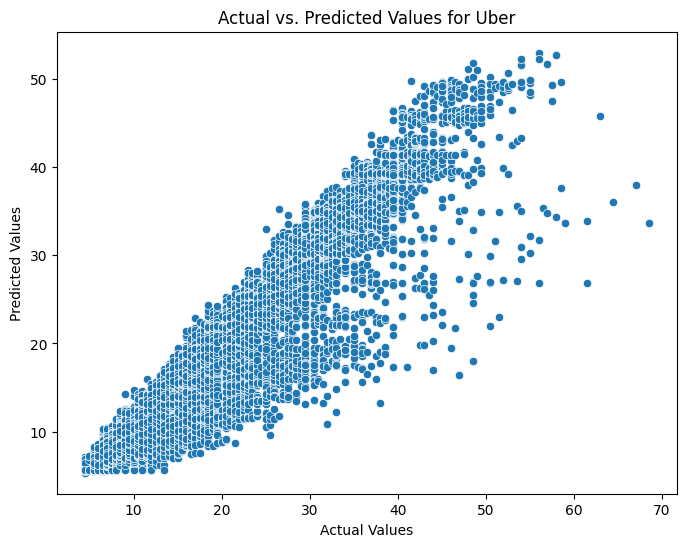

In [ ]:
# Plot a scatter plot to compare actual vs. predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=result_df_uber, palette='viridis')
plt.title('Actual vs. Predicted Values for Uber')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
# lyft actual vs. predicted values
y_pred_lyft_lg = lgbm_lyft_grid_search.best_estimator_.predict(X_test_lyft)

result_df_lyft= pd.DataFrame({'Actual': y_test_lyft, 'Predicted': y_pred_lyft_lg})
result_df_lyft = result_df_lyft.sort_values(by='Actual')

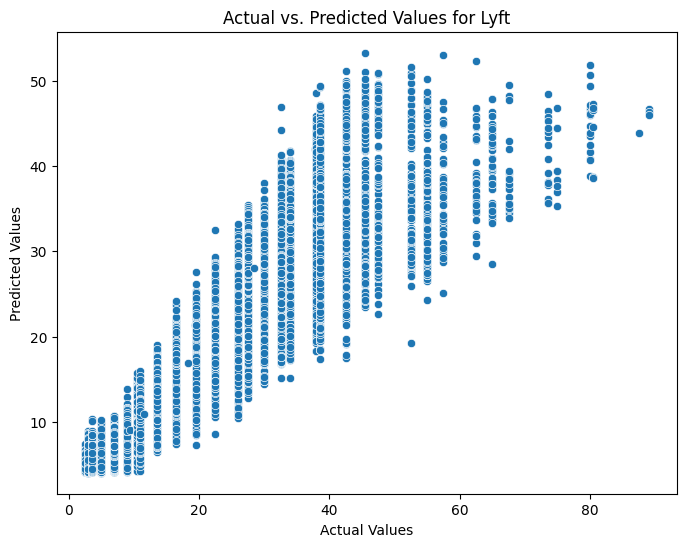

In [ ]:
# plotting compare actual against predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual', y='Predicted', data=result_df_lyft, palette='viridis')
plt.title('Actual vs. Predicted Values for Lyft')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

**Price Prediction**

In [ ]:
# Price prediction for Uber
test_data_uber = pd.DataFrame({
    'distance': [4.05],
    'destination': 'Financial District',
    'source': 'Boston University',
    'cab_type' : ['Uber'],
    'name': ['UberXL'],
    'temp': [39],
    'clouds': [0.7],
    'pressure': [1008],
    'rain': [0.05],
    'humidity': [0.76],
    'wind': [6.8],
    'time_period': ['afternoon']
})
test_data_uber

,distance,destination,source,cab_type,name,temp,clouds,pressure,rain,humidity,wind,time_period
0,4.05,Financial District,Boston University,Uber,UberXL,39,0.7,1008,0.05,0.76,6.8,afternoon


In [ ]:
# Price prediction  for Lyft
test_data_lyft = pd.DataFrame({
    'distance': [4.05],
    'destination': 'Financial District',
    'source': 'Boston University',
    'cab_type' : ['Lyft'],
    'name': ['Lyft XL'],
    'temp': [39],
    'clouds': [0.7],
    'pressure': [1008],
    'rain': [0.05],
    'humidity': [0.76],
    'wind': [6.8],
    'time_period': ['afternoon']
})
test_data_lyft

,distance,destination,source,cab_type,name,temp,clouds,pressure,rain,humidity,wind,time_period
0,4.05,Financial District,Boston University,Lyft,Lyft XL,39,0.7,1008,0.05,0.76,6.8,afternoon


In [ ]:
data_predictions_uber = lgbm_uber_grid_search.best_estimator_.predict(test_data_uber)
print("The prediction price of Uber is", data_predictions_uber)
data_predictions_lyft = lgbm_lyft_grid_search.best_estimator_.predict(test_data_lyft)
print("The prediction price of Lyft is", data_predictions_lyft)

The prediction price of Uber is [23.75728161]
The prediction price of Lyft is [23.4205802]


*Changing the Destination*

In [ ]:
test_data_uber_1 = test_data_uber.copy()
test_data_lyft_1 = test_data_lyft.copy()
test_data_uber_1['destination'] = 'Theatre District'
test_data_lyft_1['destination'] = 'Theatre District'
test_data_uber_1['distance'] = 2.9
test_data_lyft_1['distance'] = 2.9
data_predictions_uber = lgbm_uber_grid_search.best_estimator_.predict(test_data_uber_1)
print("The prediction price of Uber is", data_predictions_uber)
data_predictions_lyft = lgbm_lyft_grid_search.best_estimator_.predict(test_data_lyft_1)
print("The prediction price of Lyft is", data_predictions_lyft)

The prediction price of Uber is [17.78001047]
The prediction price of Lyft is [19.8197537]


*Changing the time period*

In [ ]:
# Change the time_period
test_data_uber_2 = test_data_uber.copy()
test_data_lyft_2 = test_data_lyft.copy()
test_data_uber_2['time_period'] = 'evening'
test_data_lyft_2['time_period'] = 'evening'
data_predictions_uber = lgbm_uber_grid_search.best_estimator_.predict(test_data_uber_2)
print("The prediction price of Uber is", data_predictions_uber)
data_predictions_lyft = lgbm_lyft_grid_search.best_estimator_.predict(test_data_lyft_2)
print("The prediction price of Lyft is", data_predictions_lyft)

The prediction price of Uber is [23.75728161]
The prediction price of Lyft is [23.4205802]


*Changing Vehicle Type*

In [ ]:
# Change the Vehicle type
test_data_uber_2 = test_data_uber.copy()
test_data_lyft_2 = test_data_lyft.copy()
test_data_uber_2['name'] = 'Black SUV'
test_data_lyft_2['name'] = 'Lux Black XL'
data_predictions_uber = lgbm_uber_grid_search.best_estimator_.predict(test_data_uber_2)
print("The prediction price of Uber is", data_predictions_uber)
data_predictions_lyft = lgbm_lyft_grid_search.best_estimator_.predict(test_data_lyft_2)
print("The prediction price of Lyft is", data_predictions_lyft)

test_data_uber_1

The prediction price of Uber is [40.24307586]
The prediction price of Lyft is [47.74800613]


,distance,destination,source,cab_type,name,temp,clouds,pressure,rain,humidity,wind,time_period
0,2.9,Theatre District,Boston University,Uber,UberXL,39,0.7,1008,0.05,0.76,6.8,afternoon


**Prediction on Test Data**

In [ ]:
# Uber predictions with best estimator
data_predictions_uber = lgbm_uber_grid_search.best_estimator_.predict(X_test_uber)
data_predictions_uber = pd.DataFrame(data_predictions_uber)
X_test_uber = X_test_uber.reset_index()
X_test_uber['predicted_price'] = data_predictions_uber
X_test_uber.head(10)

,index,distance,cab_type,destination,source,name,temp,clouds,pressure,rain,humidity,wind,time_period,predicted_price
0,133851,0.55,Uber,South Station,Theatre District,Black SUV,31.99000,0.50000,1020.73000,0.000000,0.81000,4.6700,noon,26.904565
1,157307,5.56,Uber,Boston University,Financial District,WAV,45.07000,0.25000,1003.17000,0.000000,0.62000,8.4400,night,15.716434
2,315770,2.66,Uber,Fenway,Theatre District,UberX,35.66000,0.20000,1024.20000,0.000000,0.78000,1.8800,night,10.455481
3,1963,0.63,Uber,Financial District,South Station,WAV,46.75000,0.99000,1021.66000,0.000000,0.88000,5.6700,noon,7.385405
4,470113,0.62,Uber,West End,Haymarket Square,UberXL,40.31000,0.94000,1015.19000,0.000000,0.94000,2.9150,noon,10.611678
5,247945,1.04,Uber,Financial District,North End,Black,39.82000,0.96000,1000.89000,0.000000,0.81000,6.4300,afternoon,15.816397
6,379463,2.29,Uber,North Station,South Station,UberPool,41.23500,0.87750,994.00000,0.000000,0.63000,9.3325,evening,8.653473
7,598820,4.40,Uber,Financial District,Fenway,UberXL,26.50000,0.21000,1034.04000,0.000000,0.81000,3.0800,noon,21.945237
8,81640,0.39,Uber,South Station,Financial District,UberX,32.79000,0.88000,1020.16000,0.000000,0.79000,4.2500,morning,7.289235
9,51744,3.01,Uber,Boston University,North Station,Black,43.85625,0.98125,1006.07625,0.150525,0.90875,10.3975,night,24.680139


In [ ]:
# Lyft predictions with best estimator
data_predictions_lyft = lgbm_lyft_grid_search.best_estimator_.predict(X_test_lyft)
data_predictions_lyft = pd.DataFrame(data_predictions_lyft)
X_test_lyft = X_test_lyft.reset_index()
X_test_lyft['predicted_price'] = data_predictions_lyft
X_test_lyft.head(10)

,index,distance,cab_type,destination,source,name,temp,clouds,pressure,rain,humidity,wind,time_period,predicted_price
0,296379,1.55,Lyft,Fenway,Back Bay,Lyft XL,39.000,1.000,1002.07,0.0000,0.84,6.280,afternoon,13.195628
1,393598,2.06,Lyft,South Station,North Station,Lyft XL,37.310,0.220,1005.06,0.0000,0.68,8.750,noon,14.418122
2,192837,0.62,Lyft,South Station,Theatre District,Lux Black XL,31.850,0.540,1033.43,0.0000,0.55,2.080,afternoon,27.973331
3,611480,3.31,Lyft,Northeastern University,North Station,Lux Black XL,33.600,0.740,1018.84,0.0000,0.78,3.280,late_night,36.425790
4,474377,1.46,Lyft,North End,Beacon Hill,Lyft XL,45.430,0.920,1001.11,0.0000,0.94,2.760,morning,12.584400
5,473652,2.49,Lyft,Northeastern University,Beacon Hill,Lux,29.850,0.050,1016.53,0.0000,0.84,3.160,noon,18.240521
6,233537,1.70,Lyft,South Station,West End,Lyft,42.180,1.000,1012.16,0.2006,0.77,11.340,night,9.639688
7,229781,2.91,Lyft,Theatre District,Boston University,Lux Black,44.665,0.955,988.37,0.0000,0.91,5.365,noon,27.535464
8,44836,4.33,Lyft,Financial District,Fenway,Lux Black XL,45.010,0.240,1003.18,0.0000,0.62,9.060,night,43.516999
9,316605,2.98,Lyft,Fenway,West End,Lyft XL,38.330,1.000,1020.70,0.0000,0.83,2.750,morning,16.721835


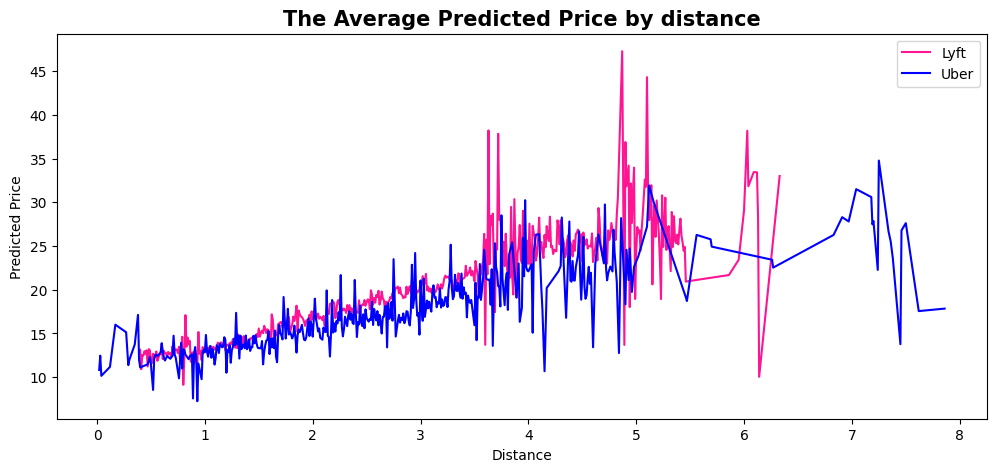

In [ ]:
# plotting distance against predicted price
fig , ax = plt.subplots(figsize = (12,5))
ax.plot(X_test_lyft.groupby('distance').predicted_price.mean().index, X_test_lyft.groupby('distance').predicted_price.mean(), label = 'Lyft', color='deeppink')
ax.plot(X_test_uber.groupby('distance').predicted_price.mean().index, X_test_uber.groupby('distance').predicted_price.mean(), label = 'Uber', color='blue')
ax.set_title('The Average Predicted Price by distance', fontsize= 15, fontweight='bold')
ax.set(xlabel = 'Distance', ylabel = 'Predicted Price' )
ax.legend()
plt.show()

The plot illustrates the relationship between distance and the average predicted price for both Uber and Lyft. Notably, the average predicted prices tend to be consistently higher than the actual prices. As the distance increases beyond five miles, the predicted prices show greater variability, which could be due to a reduced number of data points in this range. This fluctuation may indicate challenges in accurately predicting prices for longer distances, particularly when fewer examples are available in the dataset.

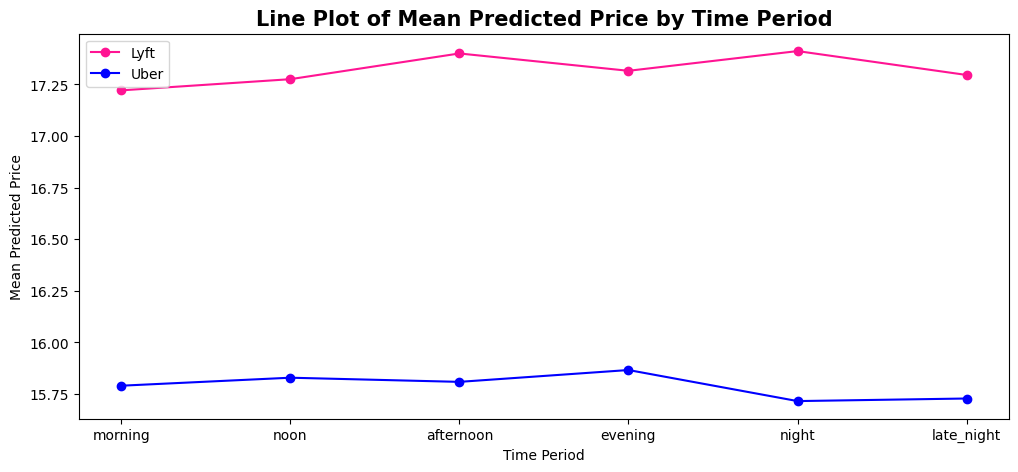

In [ ]:
# plotting time period against predicted price
time_period_order = ['morning', 'noon', 'afternoon', 'evening', 'night', 'late_night']
fig, ax = plt.subplots(figsize=(12, 5))

# reorder the dataframe based on time_period_order
lyft_df_ordered = X_test_lyft.groupby('time_period').predicted_price.mean().loc[time_period_order]
uber_df_ordered = X_test_uber.groupby('time_period').predicted_price.mean().loc[time_period_order]

ax.plot(lyft_df_ordered.index, lyft_df_ordered, label='Lyft', color='deeppink', linestyle='-', marker='o')
ax.plot(uber_df_ordered.index, uber_df_ordered, label='Uber', color='blue', linestyle='-', marker='o')

ax.set_title('Line Plot of Mean Predicted Price by Time Period', fontsize=15, fontweight='bold')
ax.set(xlabel='Time Period', ylabel='Mean Predicted Price')
ax.legend()

plt.show()

Overall, the average predicted price for Lyft is constantly higher than Uber.

Unexpectedly, we observed a price decrease during the evening period for Lyft, in contrast to a price increase for Uber. We speculate that Lyft reduces prices during this time to enhance competitiveness, particularly during peak demand hours.

**Conclusion**

In conclusion, The LGBM regression model emerged as the top performer in predicting Uber and Lyft prices, achieving the lowest root mean squared error (RMSE) among the models tested. This indicates its superior accuracy in forecasting ride prices based on the dataset used.

In our approach to supervised machine learning for predicting surge pricing, we emphasized the need to identify a model that balances accuracy with computational efficiency. Given constraints on time and computational resources, we strategically selected and tuned a limited set of hyperparameters to optimize our models for both Uber and Lyft separately.

Through feature importance analysis, we identified that the distance traveled was the most critical factor influencing price predictions for both ride-sharing services. Other significant features included location-based attributes such as pick-up location, destination, and the time period of the ride.

When comparing actual versus predicted prices, the LGBM models demonstrated strong alignment, with most predictions closely matching or slightly underestimating the actual fares. The majority of the predictions were within a $5 margin of the actual prices, highlighting the model's reliability.

Overall, our analysis and modeling offer a robust framework for predicting Uber and Lyft prices based on various factors, including trip details, geographic locations, vehicle types, and external conditions like weather. The LGBM model's superior performance suggests its potential for integration into passenger travel planning and budgeting tools, providing users with accurate price estimates based on historical data trends.

